In [1]:
import os
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from osgeo import gdal
import rasterio
from scipy.interpolate import interp2d
from numpy.ma import masked_array
import glob
import h5py
from datetime import datetime, timedelta

# this is Andrew Watson's library of functions, see https://github.com/Active-Tectonics-Leeds/interseismic_practical
import sys
import interseis_lib as lib

In [2]:
asc_wd = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/ne_iran_data/086A_05410_131313/"
desc_wd = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/ne_iran_data/166D_05342_131313/"
par_file_asc = os.path.join(asc_wd,'EQA.dem_par')
par_file_desc = os.path.join(desc_wd,'EQA.dem_par')

pattern = os.path.join(asc_wd,'*cum.h5')
matching_files = glob.glob(pattern)
asc_cum_path = matching_files[0]

pattern = os.path.join(desc_wd,'*cum.h5')
matching_files = glob.glob(pattern)
desc_cum_path = matching_files[0]

# import mask with 0.3 coh, else standard param
asc_mask_path = os.path.join(asc_wd,'mask.geo.tif')
desc_mask_path = os.path.join(desc_wd,'mask.geo.tif')
print(desc_mask_path)

/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/ne_iran_data/166D_05342_131313/mask.geo.tif


In [3]:
# Import cum files 
with h5py.File(asc_cum_path, 'r') as file:
    imdates = file['imdates']
    asc_imdates = imdates[:] 
    vel = file['vel']
    asc_vel = vel[:]
    cum = file['cum']
    asc_cum = cum[:]

with h5py.File(desc_cum_path, 'r') as file:
    imdates = file['imdates']
    desc_imdates = imdates[:] 
    vel = file['vel']
    desc_vel = vel[:]
    cum = file['cum']
    desc_cum = cum[:]
    for key in file.keys():
        print(key)

E.geo
N.geo
U.geo
bperp
coh_avg
corner_lat
corner_lon
cum
gap
hgt
imdates
maxTlen
n_gap
n_ifg_noloop
n_loop_err
n_unw
post_lat
post_lon
refarea
resid_rms
slc.mli
vel
vintercept


In [4]:
# Convert all dates to real dates

asc_dates = []
for date_value in asc_imdates:
    date_string = str(date_value)  # Convert int32 to string
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:])
    real_date = datetime(year, month, day)
    asc_dates.append(real_date)

desc_dates = []
for date_value in desc_imdates:
    date_string = str(date_value)  # Convert int32 to string
    year = int(date_string[:4])
    month = int(date_string[4:6])
    day = int(date_string[6:])
    real_date = datetime(year, month, day)
    desc_dates.append(real_date)

In [5]:
#calc below, long and tedious

width_asc = int(lib.get_par(par_file_asc,'width'))
length_asc = int(lib.get_par(par_file_asc,'nlines'))

width_desc = int(lib.get_par(par_file_desc,'width'))
length_desc = int(lib.get_par(par_file_desc,'nlines'))

# get corner positions
corner_lat_asc = float(lib.get_par(par_file_asc, 'corner_lat'))
corner_lon_asc = float(lib.get_par(par_file_asc,'corner_lon'))

corner_lat_desc = float(lib.get_par(par_file_desc,'corner_lat'))
corner_lon_desc = float(lib.get_par(par_file_desc,'corner_lon'))

# get post spacing (distance between velocity measurements)
post_lat_asc = float(lib.get_par(par_file_asc,'post_lat'))
post_lon_asc = float(lib.get_par(par_file_asc,'post_lon'))

post_lat_desc = float(lib.get_par(par_file_desc,'post_lat'))
post_lon_desc = float(lib.get_par(par_file_desc,'post_lon'))

# calculate grid spacings
lat_asc = corner_lat_asc + post_lat_asc*np.arange(1,length_asc+1) - post_lat_asc/2
lon_asc = corner_lon_asc + post_lon_asc*np.arange(1,width_asc+1) - post_lon_asc/2

lat_desc = corner_lat_desc + post_lat_desc*np.arange(1,length_desc+1) - post_lat_desc/2
lon_desc = corner_lon_desc + post_lon_desc*np.arange(1,width_desc+1) - post_lon_desc/2

In [6]:
# cum shape is (t, lat, lon)
# we want to make an array of (pixels, time)
# we want to reshape cum (202, 268, 327) into (202,(268*327))
asc_cum_shape = asc_cum.shape
n_pix = asc_cum_shape[1] * asc_cum_shape[2]
asc_cum_reshape = (asc_cum_shape[0], n_pix)

asc_cum_ = np.reshape(asc_cum, asc_cum_reshape)

desc_cum_shape = desc_cum.shape
n_pix = desc_cum_shape[1] * desc_cum_shape[2]
desc_cum_reshape = (desc_cum_shape[0], n_pix)

desc_cum_ = np.reshape(desc_cum, desc_cum_reshape)

# cum_ arrays are (pixels,time)
print(asc_cum.shape)

(202, 268, 327)


In [7]:
# we have asc_cum of shape 202, 268, 327 and mask tif. We want to mask asc_cum with mask tif 
# i.e. make pixels in asc_cum nan where mask_tif = 0. NaNs are where no data e.g. outside of frame, low coh...

#desc
desc_cum__shape = desc_cum_.shape

with rasterio.open(desc_mask_path) as tif:
    # Read the raster data
    desc_mask_tif = tif.read(1)  # Assuming a single-band raster, adjust the index if needed

# Reshape the mask to 1D
desc_mask_1d = desc_mask_tif.flatten()

# Tile the first row along the rows to match the shape of asc_cum_
desc_mask_2d = np.tile(desc_mask_1d, (desc_cum__shape[0],1))

# Apply the mask to every element in the 3D array
desc_cum_masked = desc_cum_ * desc_mask_2d

#asc
asc_cum__shape = asc_cum_.shape

with rasterio.open(asc_mask_path) as tif:
    # Read the raster data
    asc_mask_tif = tif.read(1)  # Assuming a single-band raster, adjust the index if needed

# Reshape the mask to 1D
asc_mask_1d = asc_mask_tif.flatten()

# Tile the first row along the rows to match the shape of asc_cum_
asc_mask_2d = np.tile(asc_mask_1d, (asc_cum__shape[0],1))

# Apply the mask to every element in the 3D array
asc_cum_masked = asc_cum_ * asc_mask_2d

zero_pixels_desc_orig = np.all(desc_cum_masked == 0, axis=0)

In [8]:
# Check if there are any NaN values in your data_array
has_nans = np.isnan(desc_cum_masked).any()

if has_nans:
    print("Desc data contains NaN values.")
else:
    print("Desc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (desc_cum_masked == 0).any()

if has_zeroes:
    print("Desc data contains zero values.")
else:
    print("Desc data does not contain zero values.")

# for asc
has_nans = np.isnan(asc_cum_masked).any()

if has_nans:
    print("Asc data contains NaN values.")
else:
    print("Asc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (asc_cum_masked == 0).any()

if has_zeroes:
    print("Asc data contains zero values.")
else:
    print("Asc data does not contain zero values.")

Desc data contains NaN values.
Desc data contains zero values.
Asc data contains NaN values.
Asc data contains zero values.


Text(0, 0.5, 'time (ifgs)')

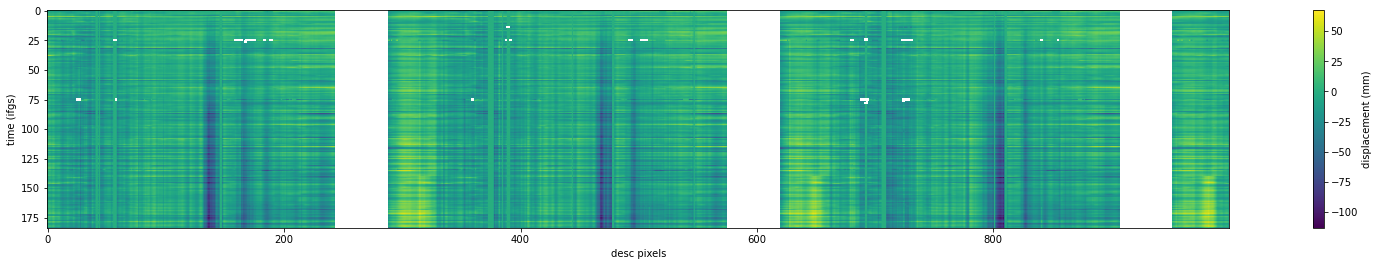

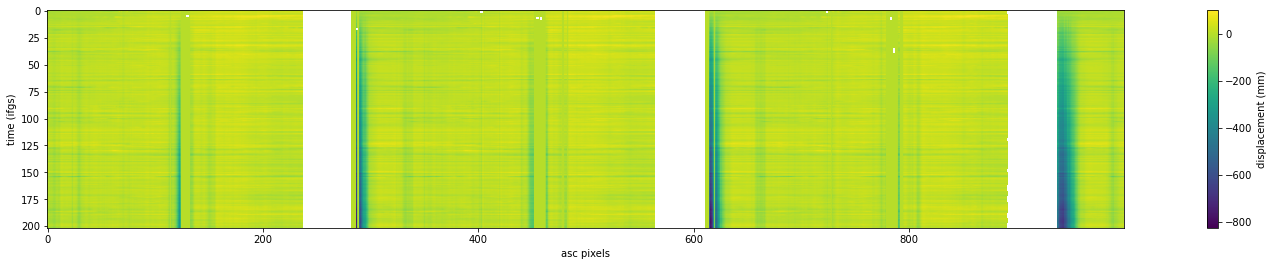

In [9]:
plt.figure(figsize=(30,4))

plt.imshow(desc_cum_masked[:,20000:21000])
plt.colorbar(label='displacement (mm)')
plt.xlabel('desc pixels')
plt.ylabel('time (ifgs)')

plt.figure(figsize=(30,4))

plt.imshow(asc_cum_masked[:,20000:21000])
plt.colorbar(label='displacement (mm)')
plt.xlabel('asc pixels')
plt.ylabel('time (ifgs)')

In [10]:
# Need to remove zeros now i have added mask in

# for descending
# Find columns (pixels) containing zeros
zero_pixels_desc = np.all(desc_cum_masked == 0, axis=0)

# Create a new data array without columns (pixels) containing all zeros
desc_cum_no_zeros = desc_cum_masked[:, ~zero_pixels_desc]
print('Desc data shape without zeros', desc_cum_no_zeros.shape)

# for ascending
# Find columns (pixels) containing zeros
zero_pixels_asc = np.all(asc_cum_masked == 0, axis=0)

# Create a new data array without columns (pixels) containing all zeros
asc_cum_no_zeros = asc_cum_masked[:, ~zero_pixels_asc]
print('Asc data shape without zeros', asc_cum_no_zeros.shape)


# Print how many NaNs there are
nan_indices_desc = np.argwhere(np.isnan(desc_cum_no_zeros))
print('There are {} desc NaNs'.format(nan_indices_desc.shape[0]))
print('Desc data with NaNs shape', desc_cum_no_zeros.shape)

# find rows containing NaNs and zeroes
nan_pixels_desc = np.any(np.isnan(desc_cum_no_zeros), axis=0)

# create a new data array without nan columns (pixels)
desc_cum_no_zeros_no_nans = desc_cum_no_zeros[:, ~nan_pixels_desc]
print('Asc data shape', desc_cum_no_zeros_no_nans.shape)

# for ascending
# Print how many NaNs there are
nan_indices_asc = np.argwhere(np.isnan(asc_cum_no_zeros))
print('There are {} asc NaNs'.format(nan_indices_asc.shape[0]))
print('Asc data with NaNs shape', asc_cum_no_zeros.shape)

# find columns containing NaNs and zeroes
nan_pixels_asc = np.any(np.isnan(asc_cum_no_zeros), axis=0)

# create a new data array without nan columns (pixels)
asc_cum_no_zeros_no_nans = asc_cum_no_zeros[:, ~nan_pixels_asc]
print('Asc data shape', asc_cum_no_zeros_no_nans.shape)


Desc data shape without zeros (184, 86964)
Asc data shape without zeros (202, 85736)
There are 5188774 desc NaNs
Desc data with NaNs shape (184, 86964)
Asc data shape (184, 55636)
There are 5453024 asc NaNs
Asc data with NaNs shape (202, 85736)
Asc data shape (202, 58481)


In [11]:
# find columns with all zeros and nans for later
zero_desc_ind = np.argwhere(zero_pixels_desc).flatten()
non_zero_desc_ind = np.argwhere(~zero_pixels_desc).flatten()

nans_desc = np.any(np.isnan(desc_cum_masked), axis=0)
nan_desc_ind = np.argwhere(nans_desc).flatten()
non_nan_desc_ind = np.argwhere(~nans_desc).flatten()

zero_asc_ind = np.argwhere(zero_pixels_asc).flatten()
non_zero_asc_ind = np.argwhere(~zero_pixels_asc).flatten()

nans_asc = np.any(np.isnan(asc_cum_masked), axis=0)
nan_asc_ind = np.argwhere(nans_asc).flatten()
non_nan_asc_ind = np.argwhere(~nans_asc).flatten()


Text(0, 0.5, 'time (ifgs)')

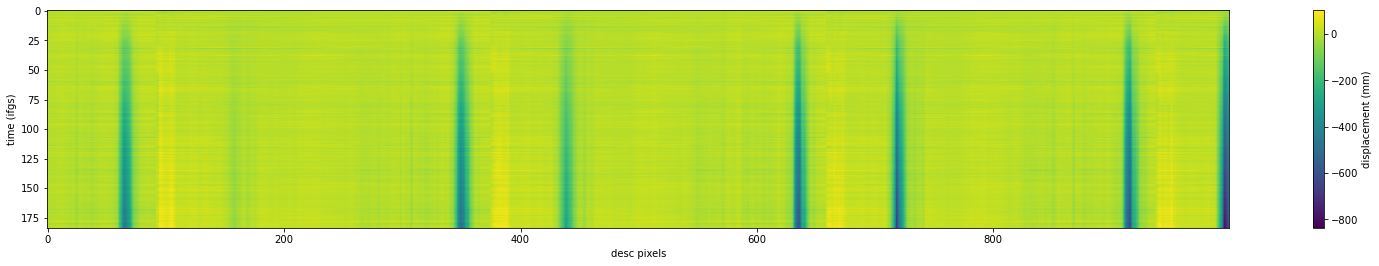

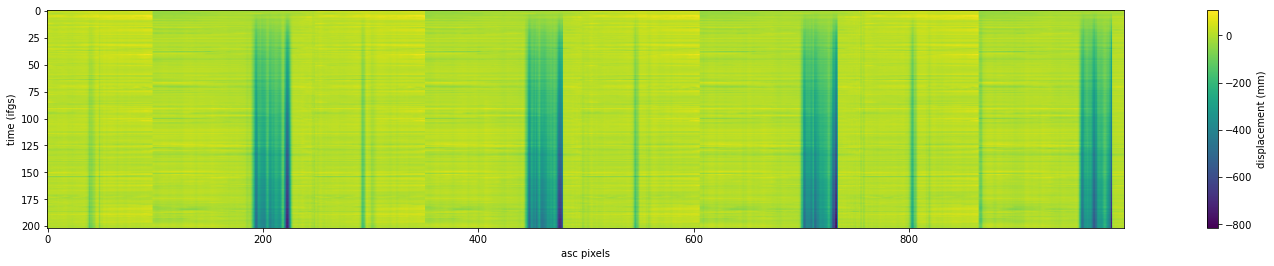

In [12]:
plt.figure(figsize=(30,4))

plt.imshow(desc_cum_no_zeros_no_nans[:,20000:21000])
plt.colorbar(label='displacement (mm)')
plt.xlabel('desc pixels')
plt.ylabel('time (ifgs)')

plt.figure(figsize=(30,4))

plt.imshow(asc_cum_no_zeros_no_nans[:,20000:21000])
plt.colorbar(label='displacement (mm)')
plt.xlabel('asc pixels')
plt.ylabel('time (ifgs)')

In [13]:
has_nans = np.isnan(desc_cum_no_zeros_no_nans).any()

if has_nans:
    print("Desc data contains NaN values.")
else:
    print("Desc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (desc_cum_no_zeros_no_nans == 0).any()

if has_zeroes:
    print("Desc data contains zero values.")
else:
    print("Desc data does not contain zero values.")

print(desc_cum_no_zeros_no_nans.shape)

# for asc
has_nans = np.isnan(asc_cum_no_zeros_no_nans).any()

if has_nans:
    print("Asc data contains NaN values.")
else:
    print("Asc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (asc_cum_no_zeros_no_nans == 0).any()

if has_zeroes:
    print("Asc data contains zero values.")
else:
    print("Asc data does not contain zero values.")

print(asc_cum_no_zeros_no_nans.shape)

Desc data does not contain NaN values.
Desc data contains zero values.
(184, 55636)
Asc data does not contain NaN values.
Asc data contains zero values.
(202, 58481)


### Descending ICA and results

In [14]:
# attempt ICA
ncomponents=5

desc = desc_cum_no_zeros_no_nans # choose original data with nan_to_num, data with nans removed, or data with nans removed and cumulative

# set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
ica = FastICA(n_components=ncomponents, whiten="unit-variance")

# fit the transformeter to the data array
S_ft = ica.fit_transform(desc) # fit model and recover signals
S_t = ica.transform(desc) # recover sources from x using unmixing matrix
## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform


In [15]:
# ica result has objects whitening matrix and mixing matrix

print('Data array shape: {}'.format(desc.shape))
print('ICA component matrix shape: {}'.format(S_ft.shape))
print('Whitening matrix shape:{}'.format(ica.whitening_.shape))
print('Mixing matrix shape: {}'.format(ica.mixing_.shape))
print(S_t.shape)

Data array shape: (184, 55636)
ICA component matrix shape: (184, 5)
Whitening matrix shape:(5, 55636)
Mixing matrix shape: (55636, 5)
(184, 5)


In [16]:
# For comparison, compute PCA
pca = PCA(n_components=ncomponents)
H = pca.fit_transform(desc)  # Reconstruct signals based on orthogonal components

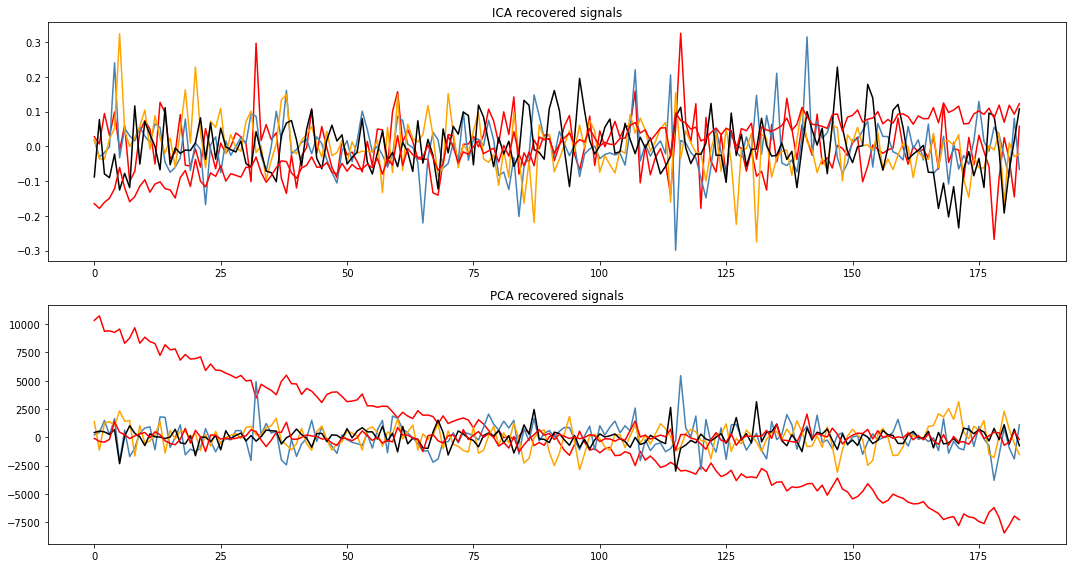

In [17]:
# plot results

plt.figure(figsize=(15,8))

models = [S_ft, H]
names = [
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange", "black","red", "steelblue", "orange", "black","blue","purple"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(2, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

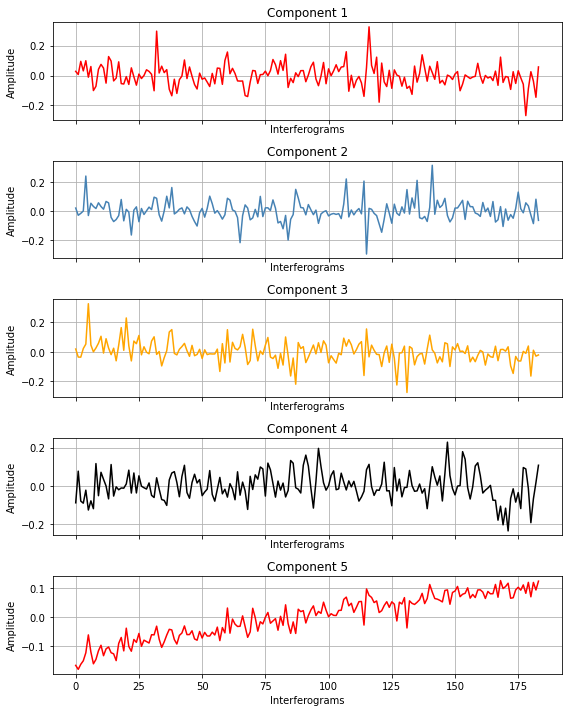

In [18]:
# plot results

fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

models = [S_ft]
names = "Component"
colors = ["red", "steelblue", "orange", "black","red", "steelblue", "orange", "black","blue","purple"]

for i, ax in enumerate(axes):
    ax.plot(S_ft[:,i], color=colors[i])  # You can customize the color
    ax.set_title(f'{names} {i + 1}')
    ax.set_xlabel("Interferograms")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

plt.tight_layout()
plt.savefig('descending_components_time.png', dpi=300)

In [19]:
restored_signals_outer = []

# Take each signal and restore with outer product
for j in range(ncomponents):
    S_j = np.copy(S_ft)
    signal = S_j[:,j]
    mixing = ica.mixing_[:,j]
    restored_signal_j = np.outer(signal, mixing)
        
    # Append the restored signal to the list
    restored_signals_outer.append(restored_signal_j)
    print(restored_signal_j.shape)

# Access the restored signals
print("Number of Restored Signals:", len(restored_signals_outer))
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    print(f"Restored Signal {i} Shape:\n{restored_signal.shape}")

(184, 55636)
(184, 55636)
(184, 55636)
(184, 55636)
(184, 55636)
Number of Restored Signals: 5
Restored Signal 1 Shape:
(184, 55636)
Restored Signal 2 Shape:
(184, 55636)
Restored Signal 3 Shape:
(184, 55636)
Restored Signal 4 Shape:
(184, 55636)
Restored Signal 5 Shape:
(184, 55636)


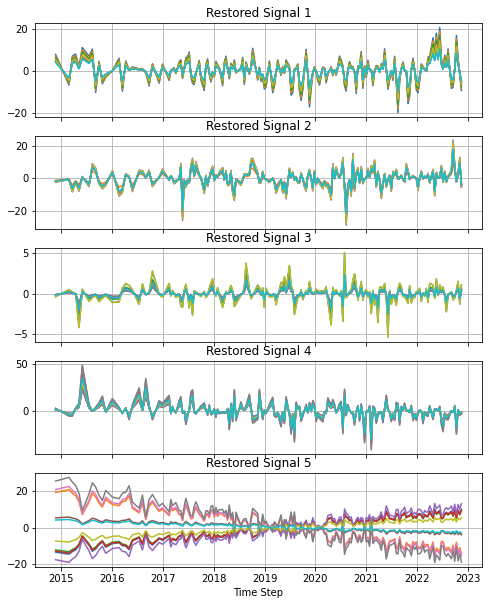

In [20]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

# Plot each restored signal on a separate subplot
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    axes[i - 1].grid()
    axes[i - 1].plot(desc_dates, restored_signal[:,:10])
    axes[i - 1].set_title(f"Restored Signal {i}")

plt.xlabel('Time Step')
plt.show()

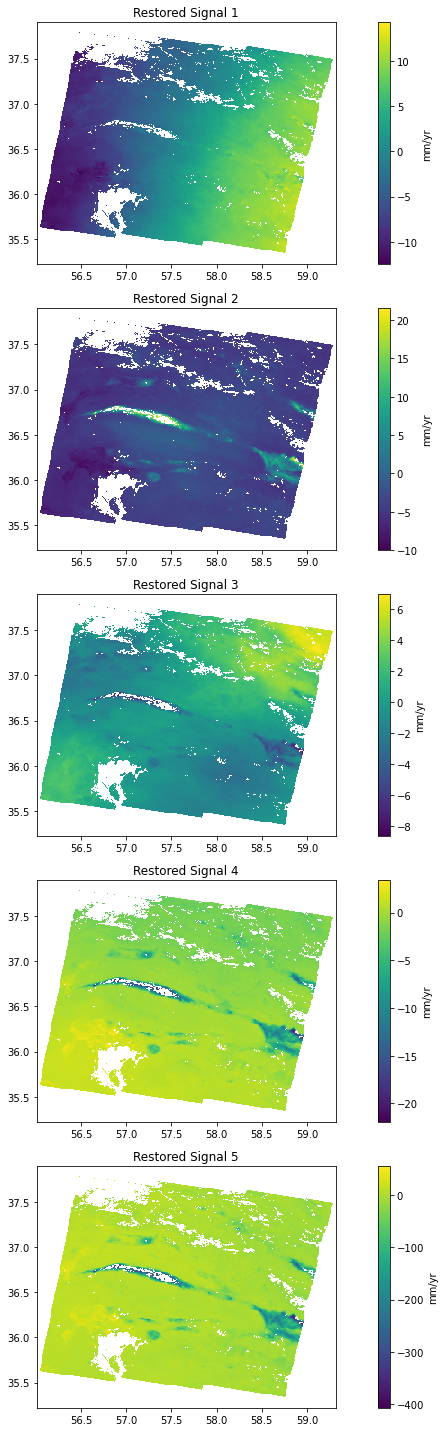

In [21]:
# Find the common indices
common_indices = np.intersect1d(non_nan_desc_ind, non_zero_desc_ind)

# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(12, 20))

# Plot each restored signal in lat, lon on a separate subplot
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    # Create a new matrix with NaNs
    desc_cum_with_nans = np.full((desc_cum_shape[2] * desc_cum_shape[1],), np.nan)

    # Assign values from the restored signal to non-NaN positions
    desc_cum_with_nans[common_indices] = restored_signal[-1]

    desc_cum_with_nans_reshaped = desc_cum_with_nans.reshape((desc_cum_shape[1], desc_cum_shape[2]))

    lon, lat = np.meshgrid(lon_desc, lat_desc)

    # Plot on the subplot
    im = axes[i - 1].imshow(desc_cum_with_nans_reshaped, extent=(lon_desc.min(), lon_desc.max(), lat_desc.min(), lat_desc.max()), cmap='viridis', interpolation ='none')
    #axes[i - 1].set_xlabel('Longitude')
    #axes[i - 1].set_ylabel('Latitude')
    axes[i - 1].set_title(f'Restored Signal {i}')
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i - 1], label='mm/yr')

plt.tight_layout()
plt.savefig('descending_component_maps.png', dpi=300)

### Ascending ICA and results

In [22]:
# asc ICA
ncomponents=6

asc = asc_cum_no_zeros_no_nans # choose original data with nan_to_num, data with nans removed, or data with nans removed and cumulative

# set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
ica = FastICA(n_components=ncomponents, whiten="unit-variance")

# fit the transformeter to the data array
S_ft = ica.fit_transform(asc) # fit model and recover signals
S_t = ica.transform(asc) # recover sources from x using unmixing matrix
## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform

In [23]:
# ica result has objects whitening matrix and mixing matrix

print('Data array shape: {}'.format(asc.shape))
print('ICA component matrix shape: {}'.format(S_ft.shape))
print('Whitening matrix shape:{}'.format(ica.whitening_.shape))
print('Mixing matrix shape: {}'.format(ica.mixing_.shape))

Data array shape: (202, 58481)
ICA component matrix shape: (202, 6)
Whitening matrix shape:(6, 58481)
Mixing matrix shape: (58481, 6)


In [24]:
# For comparison, compute PCA
pca = PCA(n_components=ncomponents)
H = pca.fit_transform(asc)  # Reconstruct signals based on orthogonal components

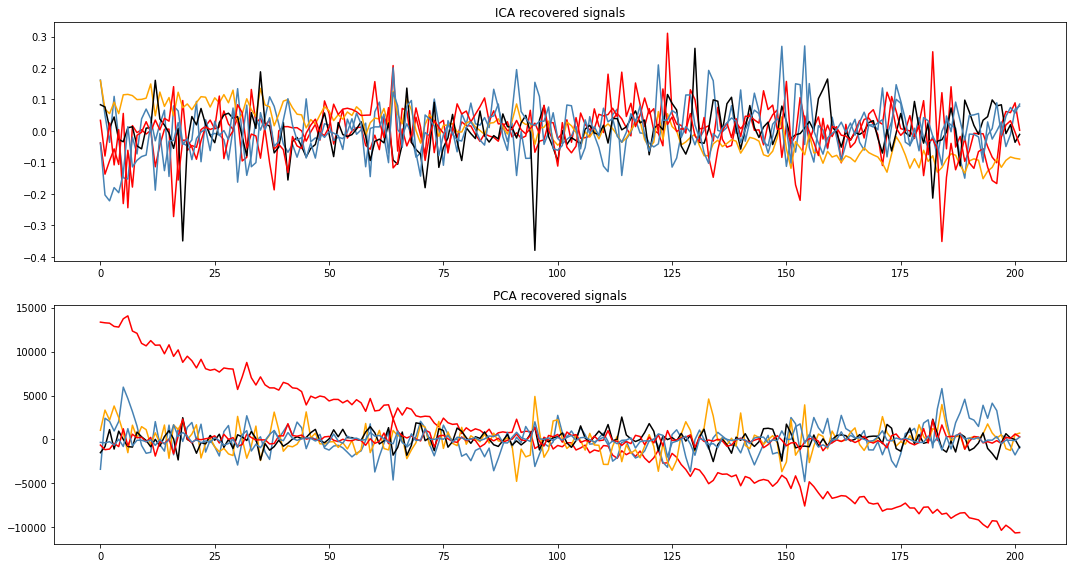

In [25]:
# plot results

plt.figure(figsize=(15,8))

models = [S_ft, H]
names = [
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange", "black","red", "steelblue", "orange", "black","blue","purple"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(2, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

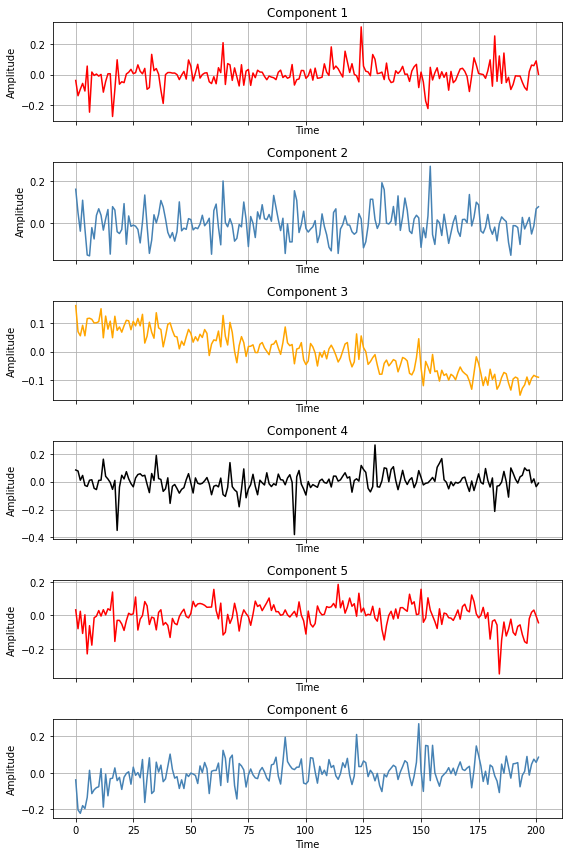

In [26]:
# plot results

fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

models = [S_ft]
names = "Component"
colors = ["red", "steelblue", "orange", "black","red", "steelblue", "orange", "black","blue","purple"]

for i, ax in enumerate(axes):
    ax.plot(S_ft[:,i], color=colors[i])  # You can customize the color
    ax.set_title(f'{names} {i + 1}')
    ax.set_xlabel("Time")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

plt.tight_layout()
plt.savefig('ascending_components_time.png', dpi=300)

In [27]:
restored_signals_outer = []

# Take each signal and restore with outer product
for j in range(ncomponents):
    S_j = np.copy(S_ft)
    signal = S_j[:,j]
    mixing = ica.mixing_[:,j]
    restored_signal_j = np.outer(signal, mixing)
        
    # Append the restored signal to the list
    restored_signals_outer.append(restored_signal_j)
    print(restored_signal_j.shape)

# Access the restored signals
print("Number of Restored Signals:", len(restored_signals_outer))
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    print(f"Restored Signal {i} Shape:\n{restored_signal.shape}")

(202, 58481)
(202, 58481)
(202, 58481)
(202, 58481)
(202, 58481)
(202, 58481)
Number of Restored Signals: 6
Restored Signal 1 Shape:
(202, 58481)
Restored Signal 2 Shape:
(202, 58481)
Restored Signal 3 Shape:
(202, 58481)
Restored Signal 4 Shape:
(202, 58481)
Restored Signal 5 Shape:
(202, 58481)
Restored Signal 6 Shape:
(202, 58481)


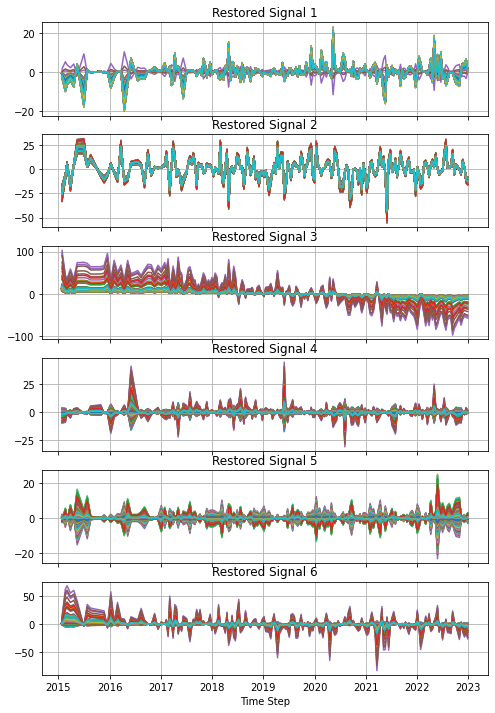

In [28]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

# Plot each restored signal on a separate subplot
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    axes[i - 1].grid()
    axes[i - 1].plot(asc_dates, restored_signal[:,:400])
    axes[i - 1].set_title(f"Restored Signal {i}")

#for ax in axes:
#    ax.xaxis_date()
#    ax.set_xticklabels(asc_imdates, rotation=45, ha='right')

plt.xlabel('Time Step')
plt.show()

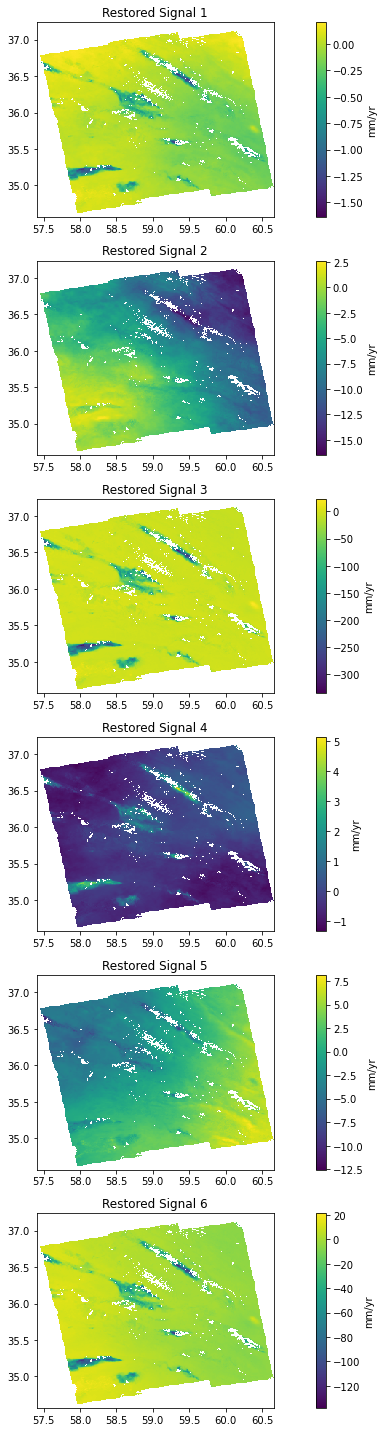

In [29]:
# Find the common indices
common_indices = np.intersect1d(non_nan_asc_ind, non_zero_asc_ind)

# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(12, 20))

# Plot each restored signal in lat, lon on a separate subplot
for i, restored_signal in enumerate(restored_signals_outer, start=1):
    # Create a new matrix with NaNs
    asc_cum_with_nans = np.full((asc_cum_shape[2] * asc_cum_shape[1],), np.nan)

    # Assign values from the restored signal to non-NaN positions
    asc_cum_with_nans[common_indices] = restored_signal[-1]

    asc_cum_with_nans_reshaped = asc_cum_with_nans.reshape((asc_cum_shape[1], asc_cum_shape[2]))

    lon, lat = np.meshgrid(lon_asc, lat_asc)

    # Plot on the subplot
    im = axes[i - 1].imshow(asc_cum_with_nans_reshaped, extent=(lon_asc.min(), lon_asc.max(), lat_asc.min(), lat_asc.max()), cmap='viridis', interpolation ='none')
    #axes[i - 1].set_xlabel('Longitude')
    #axes[i - 1].set_ylabel('Latitude')
    axes[i - 1].set_title(f'Restored Signal {i}')
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i - 1], label='mm/yr')
plt.tight_layout()
plt.savefig('ascending_component_maps.png', dpi=300)

#### Test single subsidence basin

In [34]:
#print(asc_cum_with_nans_reshaped.shape)
print(restored_signal.shape)


(202, 58481)


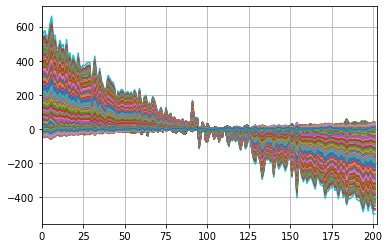

In [26]:
# Plot the restored signals
plt.figure()
plt.grid()
axes = plt.gca()
axes.set_xlim([0, (asc_cum_no_nans.shape[0])])
plt.plot(restored_signals[0])
plt.show()

In [27]:
# plot subsidence signal in lat, lon

nan_indices = np.argwhere(nan_pixels).flatten()
non_nan_indices = np.argwhere(~nan_pixels).flatten()

# take final cumualtive disp restored signal:
final_cum_asc = restored_signal_1[-1]

# Create a new matrix with NaNs
asc_cum_with_nans = np.full((asc_cum_shape[2]*asc_cum_shape[1],), np.nan)

# Assign values from final_cum_asc to non-NaN positions and NaNs to NaN positions
asc_cum_with_nans[non_nan_indices] = final_cum_asc

asc_cum_with_nans_reshaped = asc_cum_with_nans.reshape((asc_cum_shape[1], asc_cum_shape[2]))

lon, lat = np.meshgrid(lon_asc, lat_asc)

plt.scatter(lon, lat, c=asc_cum_with_nans_reshaped, cmap='viridis', marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restored Signal 1')
plt.colorbar(label='Deformation Values')
plt.show()

NameError: name 'nan_pixels' is not defined

In [ ]:
# plot subsidence signal in lat, lon

nan_indices = np.argwhere(nan_pixels).flatten()
non_nan_indices = np.argwhere(~nan_pixels).flatten()

# take final cumualtive disp restored signal:
final_cum_asc = restored_signal_3[-1]

# Create a new matrix with NaNs
asc_cum_with_nans = np.full((asc_cum_shape[2]*asc_cum_shape[1],), np.nan)

# Assign values from final_cum_asc to non-NaN positions and NaNs to NaN positions
asc_cum_with_nans[non_nan_indices] = final_cum_asc

asc_cum_with_nans_reshaped = asc_cum_with_nans.reshape((asc_cum_shape[1], asc_cum_shape[2]))

lon, lat = np.meshgrid(lon_asc, lat_asc)

plt.scatter(lon, lat, c=asc_cum_with_nans_reshaped, cmap='viridis', marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restored Signal 3')
plt.colorbar(label='Deformation Values')
plt.show()

In [ ]:
# from here: https://gist.github.com/Tetraquark/5bf052134d413f79748ce3aceaaf42df
restored_signals_dot = []

# Nullify independent components of signal 1 and signal 2  
for j in range(ncomponents):
    S_j = np.copy(S_ft)
    for i in range(len(S_j)):
        (S_j)[i,j] = 0
    restored_signal_j = np.dot(S_j, ica.mixing_.T)

    # Append the restored signal to the list
    restored_signals_dot.append(restored_signal_j)
    print(restored_signal_j.shape)

# Access the restored signals
print("Number of Restored Signals:", len(restored_signals_dot))
for i, restored_signal in enumerate(restored_signals_dot, start=1):
    print(f"Restored Signal {i} Shape:\n{restored_signal.shape}")